# Comomo analysis : uSEIR quenched LLE (CCAA) - draft

version: 05-06-2020

author : JAH, JJG

In [311]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [312]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Wed Jun 10 10:47:09 2020


In [313]:
import numpy as np
import pandas as pd
import matplotlib

In [314]:
import c19.data_functions_momo as momodata
import c19.momo_analysis       as c19ma

import c19.useir            as us
import c19.kfilter          as kf
import c19.useir_ana        as usa
import c19.cfit             as cfit

#import c19.momodata         as 

import scipy          as sp
import scipy.stats    as stats
import scipy.optimize as optimize

npa     = np.array
npdate  = np.datetime64
npdtime = np.timedelta64

## Data

Load Data comomo

In [315]:
path = '/Users/hernando/investigacion/bio/c19/cdata/'
dfv, dfe, dfc = momodata.comomo_from_csv(path=path)

In [316]:
dfc.head()

errors                                                         \
  Andalucia       Date Aragon Asturias Baleares Canarias Cantabria   
0       0.0 2020-03-05    0.0      0.0      0.0      0.0       0.0   
1       0.0 2020-03-06    1.0      0.0      0.0      0.0       0.0   
2       0.0 2020-03-07    0.0      0.0      0.0      0.0       0.0   
3       0.0 2020-03-08    1.0      0.0      0.0      0.0       0.0   
4       0.0 2020-03-09    1.0      0.0      0.0      0.0       0.0   

                                                ...      values                \
  Castilla La Mancha Castilla y Leon Cataluna   ...    Cataluna C. Valenciana   
0                0.0             0.0      0.0   ...         0.0           1.0   
1                0.0             0.0      0.0   ...         0.0          13.0   
2                0.0             0.0      1.0   ...         1.0           6.0   
3                0.0             0.0      0.0   ...         0.0           0.0   
4                0.0             0.0      1.0   ...         1.0           0.0   

                                                                         
  Extremadura Galicia Madrid Melilla Murcia Navarra Pais Vasco La Rioja  
0         0.0     0.0    1.0     0.0    5.0     0.0        1.0      0.0  
1         0.0     0.0   12.0     0.0    0.0     1.0        0.0      0.0  
2         0.0     1.5    9.0     0.0    2.5     0.0        1.5      6.0  
3         1.0     0.0    4.0     0.0    0.0     4.5        4.0      0.0  
4         3.0     0.0    8.0     0.0    0.0     0.0       16.0      2.0  

[5 rows x 38 columns]

## Example: Madrid and uSEIR-quenched fit

In [317]:
def ca_cases(caname):
    dates  = dfv.Date.values
    cases  = dfv[caname].values
    ucases = dfe[caname].values
    return dates, cases, ucases

total  14661.0


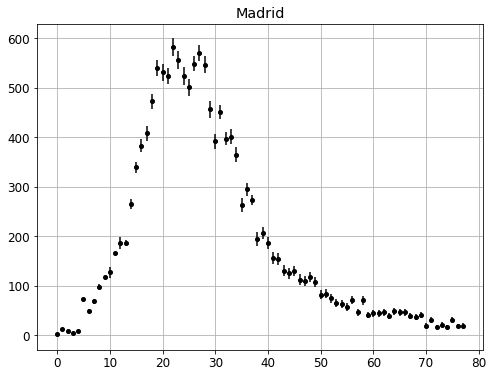

In [318]:
caname = 'Madrid'
dates, cases, ucases = ca_cases(caname)
ts                   = np.arange(len(dates))

xdata  = ts, cases

print('total ', np.sum(cases))

plt.errorbar(ts, cases, yerr = ucases, ls = '', marker = 'o', ms = 4, color = 'black')
plt.title(caname); plt.grid(); #c19ma.formatter(plt.gca());

### uSEIR-quenched with t0

In [283]:
def getpars(beta = 2.0, gamma = 0.2, tr = 3., ti = 5.5, tm = 9.8, t0 = 43, n = 3e6, phi = 0.016, s1 = 0.11):
    return npa((t0, beta, gamma, tr, ti, tm, n, phi, s1))

def getmask(names):
    xpos = {'t0':0, 'beta':1, 'gamma':2, 'tr':3, 'ti': 4, 'tm':5, 'n':6, 'phi':7, 's1':8}
    xmask = npa(9 * (False,))
    for name in names:
        xmask[xpos[name]] = True
    return xmask

def getparsdir(pars):
    xpos = {'t0':0, 'beta':1, 'gamma':2, 'tr':3, 'ti': 4, 'tm':5, 'n':6, 'phi':7, 's1':8}
    dpars = {}
    for key in xpos.keys():
        dpars[key] = pars[xpos[key]]
    return dpars
    

total  14033
mle: warning


{'t0': 27.22771502086421,
 'beta': 3.9743340412221855,
 'gamma': 0.38892460605675927,
 'tr': 1.574824890950996,
 'ti': 5.5,
 'tm': 9.8,
 'n': 3000000.0,
 'phi': 0.014189043705958852,
 's1': 0.23457388898251244}

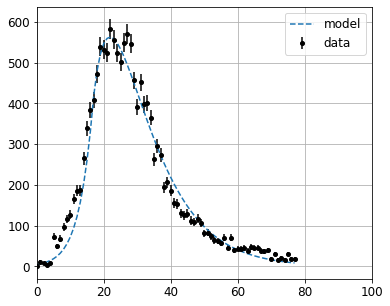

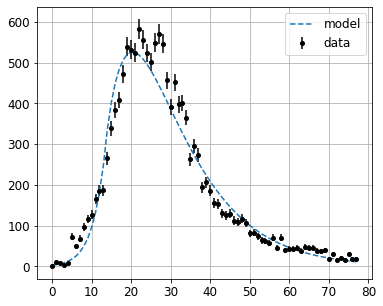

In [310]:
ufun = lambda pars : us._t0(pars, us._useirvarext)

pars = getpars(t0 = 35, beta = 1.8, gamma = 0.1, s1 = 0.20, tr = 3.)
times, xmcdata = us.rvs(pars, ufun = ufun)

xmcs, ymcs = xmcdata
print('total ', np.sum(ymcs))

#usa.plot_fit_data(xmcdata, pars, ufun= ufun)
usa.plot_fit_data(xdata, pars, ufun= ufun)
plt.xlim((0, 100));

kpars = {'t0': 35, 'beta' : 1.8, 'gamma' : 0.1, 's1' : 0.20, 'tr' : 5.}
ana_ca('Madrid', kpars = kpars)

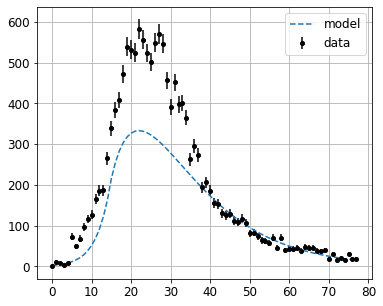

In [287]:
usa.plot_fit_data(xdata, pars, ufun= ufun)

In [127]:
def fit(fun, pars, mask = None, method = 'Delder-Mead'):
    res = cfit.minimize(pars, fun, mask = mask, method = method)

In [240]:
kmask0 = (('t0', 'phi', 's1'), ('beta', 'gamma', 'tr'))

def ana_ca(caname, kpars = {}, kmasks = kmask0, ax = None): 
    for i, kmask in enumerate(kmasks):
        ok = i == len(kmasks) - 1
        kpars = ana_ca_fit(caname, kpars, kmask, plot = ok, ax = ax)
        #print('mask: ', kmask)
        #print('pars: ', kpars)
    return kpars
    #kmask  = ('ti', 'tm')

def ana_ca_fit(caname, kpars, kmask, plot = True, ax = None):
    dates, cases, ucases = ca_cases(caname)
    ts                   = np.arange(len(dates))
    xdata  = ts, cases

    ufun = lambda pars : us._t0(pars, us._useirvarext)
    fun    = us.res(xdata, ufun = ufun)

    return ana_fit(xdata, fun, kpars, kmask, ufun, plot = plot, ax = ax)

def ana_fit(xdata, fun, kpars, kmask, ufun, plot, ax = None):
    xpars = getpars(**kpars)
    xmask = getmask(kmask)
    res   = cfit.minimize(xpars, fun, mask = xmask, method = 'Nelder-Mead')
    #print('initial pars   ', getparsdir(xpars))
    #print('estimated pars ', getparsdir(res))
    #print('initial guess  ', kmask, xpars[xmask])
    #print('estimated pars ', kmask, res[xmask])
    #print('fun value ', np.sum(fun(res)), ', initial ', np.sum(fun(xpars)))
    #usa.plot_fit_data(xdata, xpars, ufun = ufun)
    if (plot):
        usa.plot_fit_data(xdata, res  , ufun = ufun, ax = ax)
    return getparsdir(res)

### testing different parameters

{'t0': 43.0,
 'beta': 1.718595332557614,
 'gamma': 0.2,
 'tr': 3.6089703829738884,
 'ti': 5.5,
 'tm': 7.0,
 'n': 3000000.0,
 'phi': 0.016,
 's1': 0.11}

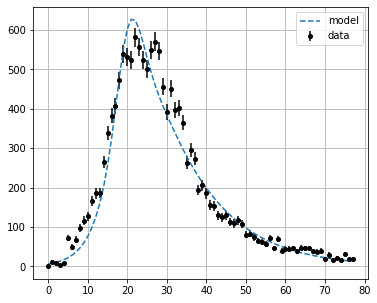

In [216]:
kpars = {'beta': 2., 'tr': 3}
kmask = ('beta', 'tr')
ana_ca_fit('Madrid', kpars, kmask)

/Users/hernando/investigacion/bio/c19/c19/useir.py:35: RuntimeWarning: invalid value encountered in true_divide
  return lambda x: xp(x)/norma


{'t0': 53.222073955726486,
 'beta': 5.0,
 'gamma': 0.6299999999999992,
 'tr': 1.0,
 'ti': 5.5,
 'tm': 7.0,
 'n': 3000000.0,
 'phi': 0.027425916590367236,
 's1': 0.10241697133106084}

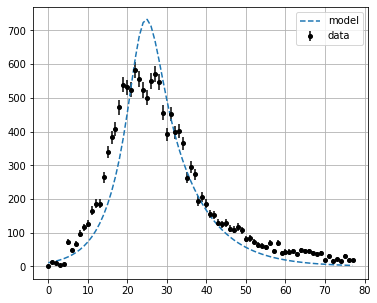

In [259]:
r0, r1 = 5., 0.6
kpars = {'t0': 41.4, 'beta': r0/1., 'gamma': r1/1., 'tr': 1., 'n': 3e6, 'phi': 0.017, 's1': 0.12}
ana_ca('Madrid', kpars)

/Users/hernando/investigacion/bio/c19/c19/useir.py:35: RuntimeWarning: invalid value encountered in true_divide
  return lambda x: xp(x)/norma


{'t0': 42.294665306931556,
 'beta': 3.1172733948929716,
 'gamma': 0.4724109490713252,
 'tr': 1.0000030726213893,
 'ti': 5.5,
 'tm': 7.0,
 'n': 3000000.0,
 'phi': 0.016343152249815758,
 's1': 0.12574220285724708}

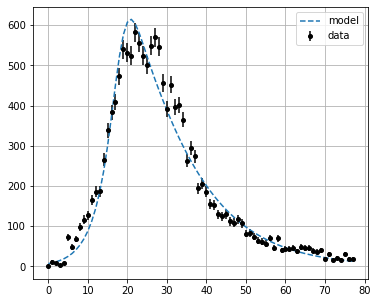

In [260]:
kpars = {'t0': 41.4, 'beta': r0/2., 'gamma': r1/2., 'tr': 2., 'n': 3e6, 'phi': 0.017, 's1': 0.12}
ana_ca('Madrid', kpars)

{'t0': 47.3849543239091,
 'beta': 1.5199098793006631,
 'gamma': 0.19653788284534918,
 'tr': 3.4089234384963816,
 'ti': 5.5,
 'tm': 7.0,
 'n': 3000000.0,
 'phi': 0.01867477732164819,
 's1': 0.11363539328832636}

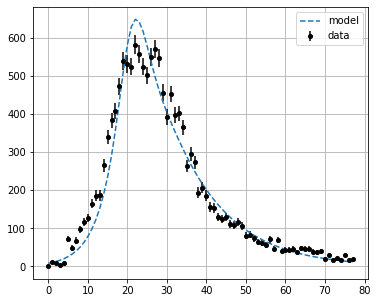

In [261]:
kpars = {'t0': 41.4, 'beta': r0/3., 'gamma': r1/3., 'tr': 3., 'n': 3e6, 'phi': 0.017, 's1': 0.12}
ana_ca('Madrid', kpars)

{'t0': 50.18113117426208,
 'beta': 1.509174965775129,
 'gamma': 0.22031496222402633,
 'tr': 3.041330757205394,
 'ti': 5.5,
 'tm': 7.0,
 'n': 3000000.0,
 'phi': 0.019259651622391908,
 's1': 0.11836763573792294}

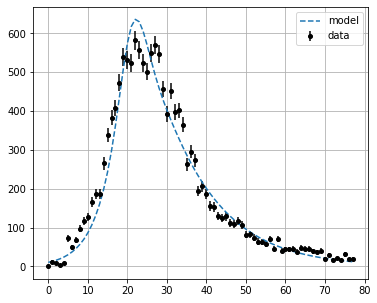

In [262]:
kpars = {'t0': 41.4, 'beta': r0/4., 'gamma': r1/4., 'tr': 4., 'n': 3e6, 'phi': 0.017, 's1': 0.12}
ana_ca('Madrid', kpars)

{'t0': 52.048004431558816,
 'beta': 1.616828818285906,
 'gamma': 0.25912617042779285,
 'tr': 2.375385977715603,
 'ti': 5.5,
 'tm': 7.0,
 'n': 3000000.0,
 'phi': 0.025160068610011188,
 's1': 0.08495774784597696}

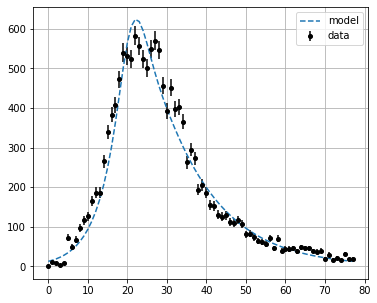

In [263]:
kpars = {'t0': 41.4, 'beta': r0/5., 'gamma': r1/5., 'tr': 5., 'n': 3e6, 'phi': 0.017, 's1': 0.12}
ana_ca('Madrid', kpars)

{'t0': 41.37497582339802,
 'beta': 2.568234674181266,
 'gamma': 0.3361491329278037,
 'tr': 1.910693044862603,
 'ti': 5.5,
 'tm': 7.0,
 'n': 3000000.0,
 'phi': 0.01747617800739982,
 's1': 0.11906264340434865}

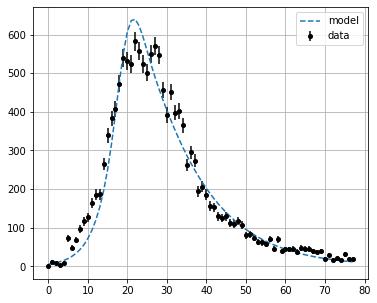

In [217]:
ana_ca('Madrid')

/Users/hernando/investigacion/bio/c19/c19/useir.py:35: RuntimeWarning: invalid value encountered in true_divide
  return lambda x: xp(x)/norma
/Users/hernando/investigacion/bio/c19/c19/useir.py:35: RuntimeWarning: invalid value encountered in true_divide
  return lambda x: xp(x)/norma


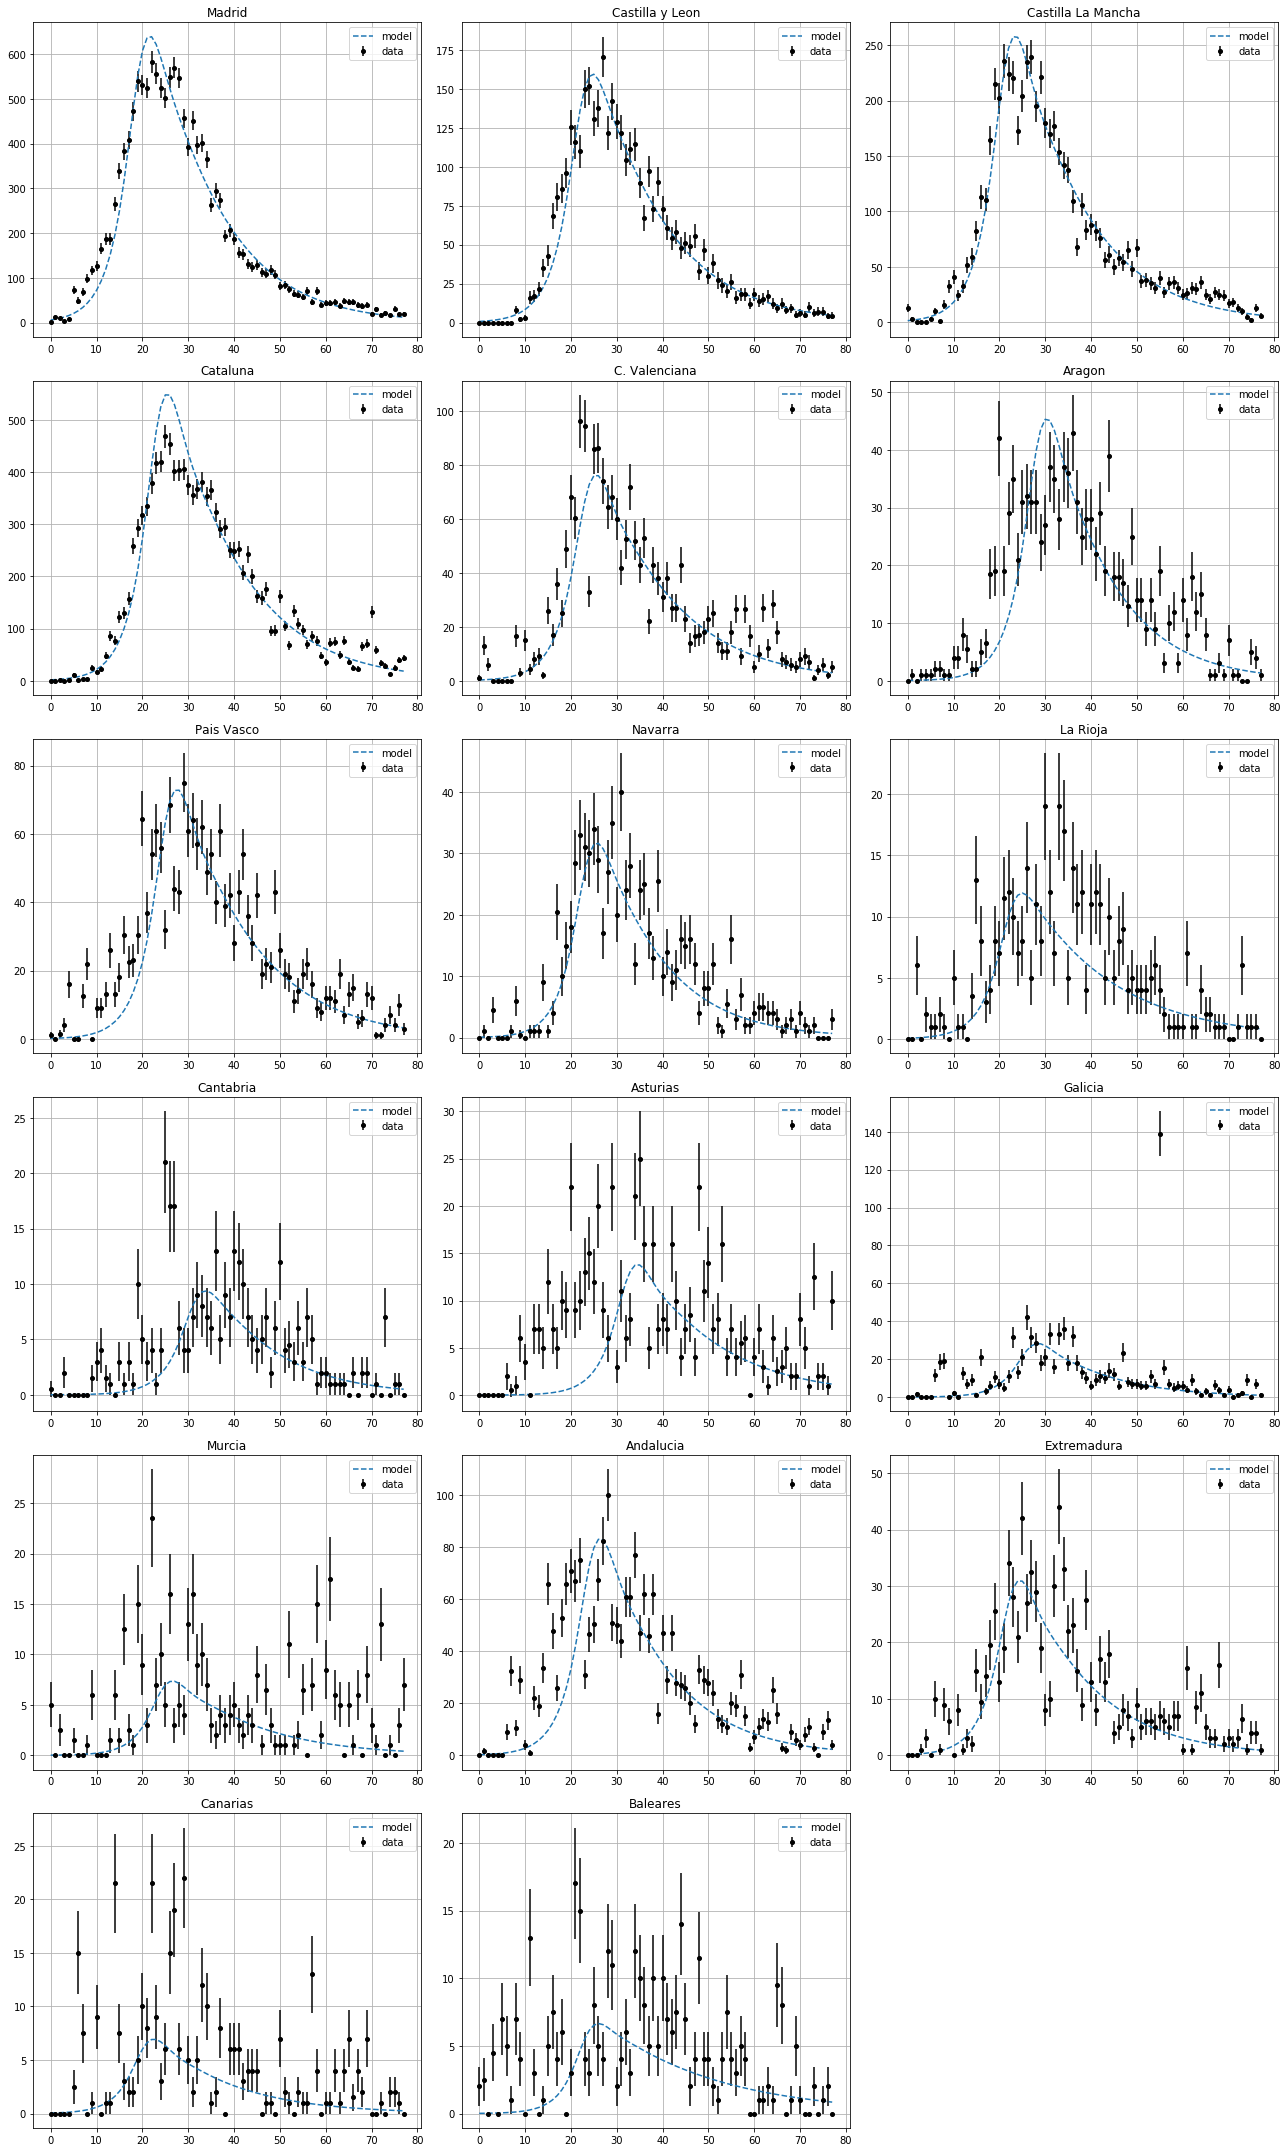

In [221]:
canames = ['Madrid', 'Castilla y Leon', 'Castilla La Mancha',
           'Cataluna', 'C. Valenciana', 'Aragon',
           'Pais Vasco', 'Navarra', 'La Rioja',
           'Cantabria', 'Asturias', 'Galicia',
           'Murcia', 'Andalucia', 'Extremadura',
           'Canarias', 'Baleares']

ncols, nrows = 3, 6
plt.figure(figsize = (ncols * 6, nrows * 5))

blind = False
capars = {}
for i, caname in enumerate(canames):
    ax = plt.subplot(nrows, ncols, i + 1, axisbelow=True)
    pars = ana_ca(caname, ax = ax)
    capars[caname] = pars
    plt.title(caname)
plt.tight_layout()

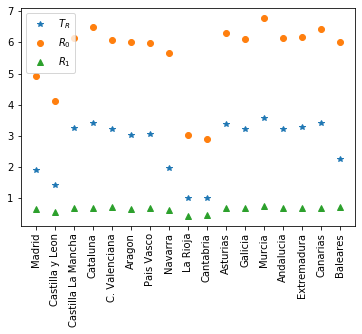

In [235]:
trs    = npa([capars[caname]['tr'] for caname in canames])
betas  = npa([capars[caname]['beta'] for caname in canames])
gammas = npa([capars[caname]['gamma'] for caname in canames])
plt.plot(trs, ls = '', marker = '*', label = r'$T_R$');
plt.plot(trs * betas, ls = '', marker = 'o', label = r'$R_0$');
plt.plot(trs * gammas, ls = '', marker = '^', label = r'$R_1$');
plt.legend();
plt.xticks(np.arange(len(canames)), canames, rotation = 90);

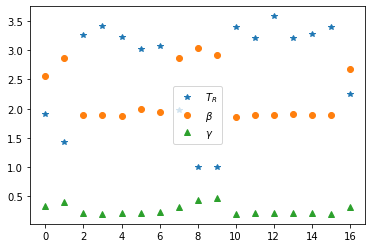

In [227]:
trs    = npa([capars[caname]['tr'] for caname in canames])
betas  = npa([capars[caname]['beta'] for caname in canames])
gammas = npa([capars[caname]['gamma'] for caname in canames])
plt.plot(trs, ls = '', marker = '*', label = r'$T_R$');
plt.plot(betas, ls = '', marker = 'o', label = r'$\beta$');
plt.plot(gammas, ls = '', marker = '^', label = r'$\gamma$');
plt.legend();

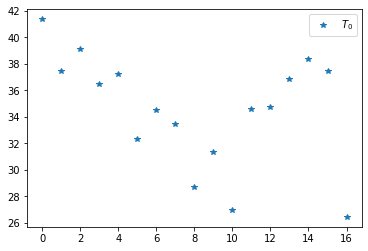

In [229]:
t0s = npa([capars[caname]['t0'] for caname in canames])
phis  = npa([capars[caname]['phi'] for caname in canames])
s1s = npa([capars[caname]['s1'] for caname in canames])
plt.plot(t0s, ls = '', marker = '*', label = r'$T_0$');
#plt.plot(betas, ls = '', marker = 'o', label = r'$\beta$');
#plt.plot(gammas, ls = '', marker = '^', label = r'$\gamma$');
plt.legend();

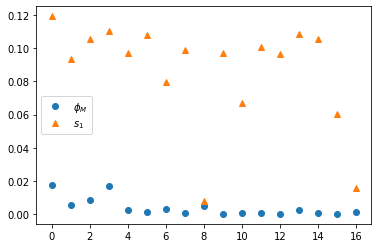

In [230]:
plt.plot(phis, ls = '', marker = 'o', label = r'$\phi_M$');
plt.plot(s1s, ls = '', marker = '^', label = r'$s_1$');
plt.legend();